## 6.3 卷积神经网络识别Fashion-MNIST

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms

### 6.3.1 图像数据准备

In [15]:
from torchvision.datasets import FashionMNIST

In [16]:
# 使用FashionMNIST数据，准备训练数据集
train_data = FashionMNIST(
    root = "D:/Data/FashionMNIST", # 数据的路径
    train = True, # 只使用训练数据集
    transform = transforms.ToTensor(),
    download = False)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, # 使用的数据集
    batch_size = 64, # 批处理样本大小
    shuffle = False, # 每次迭代前不打乱数据
    num_workers = 2 # 使用2个进程
)

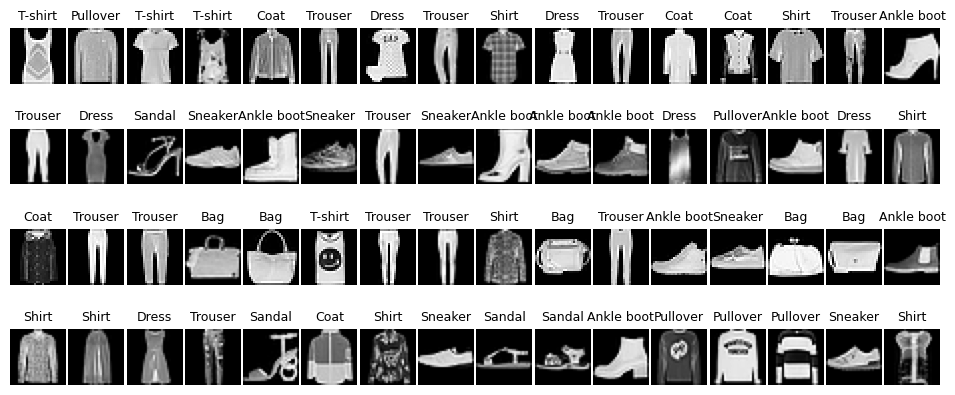

In [21]:
# 可视化并观察数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
# 可视化一个batch的图像
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
plt.figure(figsize=(12, 5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4, 16, ii+1)
    plt.imshow(batch_x[ii,:,:], cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05)

In [31]:
# 对测试集进行处理
test_data = FashionMNIST(
    root = "D:/Data/FashionMNIST", # 数据的路径
    train = False, # 只使用训练数据集
    transform = transforms.ToTensor(),
    download = False)
# 为数据添加一个通道维度，并且取值范围缩放到0-1之间
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)
test_data_y = test_data.targets # 测试集标签
print("test_data_x.shape:", test_data_x.shape)
print("test_data_y.shape:", test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


### 6.3.2 卷积神经网络的搭建

In [52]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, # 输入的feature map
                out_channels = 16, # 输出的feature map
                kernel_size = 3, # 卷积核尺寸
                stride = 1, # 卷积核步长
                padding = 1 # 进行填充
            ), # 卷积后：(1*28*28)转为(16*28*28)
            nn.ReLU(), # 激活函数
            nn.AvgPool2d(
                kernel_size = 2, # 平均值池化层，使用2*2
                stride = 2, # 池化步长为2
            ), # 池化后：(16*28*28)转为(16*14*14)
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 0
            ), # 卷积后：(16*14*14)转为(32*6*6)
            nn.ReLU(),
            nn.AvgPool2d(2, 2) # 池化后：(32*12*12)转为(32*6*6)
        )
        # 定义全连接层
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    # 定义网络的向前传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 展平多维卷积图层
        output = self.classifier(x)
        return output
# 输出网络结构
myconvnet = MyConvNet()
print(myconvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### 6.3.3 卷积神经网络训练与预测

In [61]:
# 定义网络的训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    """model：网络模型；traindataloader：训练数据集
    train_rate：训练集百分比（一些用于训练，一些用于验证）；criterion：损失函数；optimizer：优化方法"""
    # 计算训练使用的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num*train_rate)
    # 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        # 每个epoch有两个训练阶段
        train_loss= 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss +=loss.item()*b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
        
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss/train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss/val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Train Loss: {:.4f} Train Acc: {: .4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f} val Acc: {: .4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
        
        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use//60, time_use%60))
    
    # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data = {"epoch":range(num_epochs),
                "train_loss_all":train_loss_all,
                "val_loss_all":val_loss_all,
                "train_acc_all":train_acc_all,
                "val_acc_all":val_acc_all})
    return model, train_process

> 上面的train_model()函数通过train_batch_num确定用于训练的batch数量，并且在每轮的迭代中，如果step<train_batch_num，则进入训练模式，否则进入验证模式。在模型的训练和验证过程中，分别输出当前的损失函数的大小和对应的识别精度，并将它们保存在列表汇总中，最后组成数据表格train_process输出。为了保存模型最高精度下的训练参数，使用copy.deepcopy()函数将模型最优的参数保存在best_model_wts中，最终将所有的训练结果使用model.load_state_dict(best_model_wts)将最优的参数赋值给最终的模型

In [62]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
myconvnet, train_process = train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0Train Loss:  0.1382 Train Acc:  0.9497
0Val Loss:  0.2441 val Acc:  0.9191
Train and val complete in 0m 12s
Epoch 1/24
----------
1Train Loss:  0.1330 Train Acc:  0.9514
1Val Loss:  0.2480 val Acc:  0.9187
Train and val complete in 0m 23s
Epoch 2/24
----------
2Train Loss:  0.1290 Train Acc:  0.9530
2Val Loss:  0.2489 val Acc:  0.9186
Train and val complete in 0m 35s
Epoch 3/24
----------
3Train Loss:  0.1244 Train Acc:  0.9552
3Val Loss:  0.2535 val Acc:  0.9184
Train and val complete in 0m 46s
Epoch 4/24
----------
4Train Loss:  0.1208 Train Acc:  0.9561
4Val Loss:  0.2542 val Acc:  0.9191
Train and val complete in 0m 58s
Epoch 5/24
----------
5Train Loss:  0.1165 Train Acc:  0.9581
5Val Loss:  0.2584 val Acc:  0.9187
Train and val complete in 1m 10s
Epoch 6/24
----------
6Train Loss:  0.1124 Train Acc:  0.9599
6Val Loss:  0.2597 val Acc:  0.9196
Train and val complete in 1m 21s
Epoch 7/24
----------
7Train Loss:  0.1088 Train Acc:  0.9615
7Val Loss:  0.2663 va

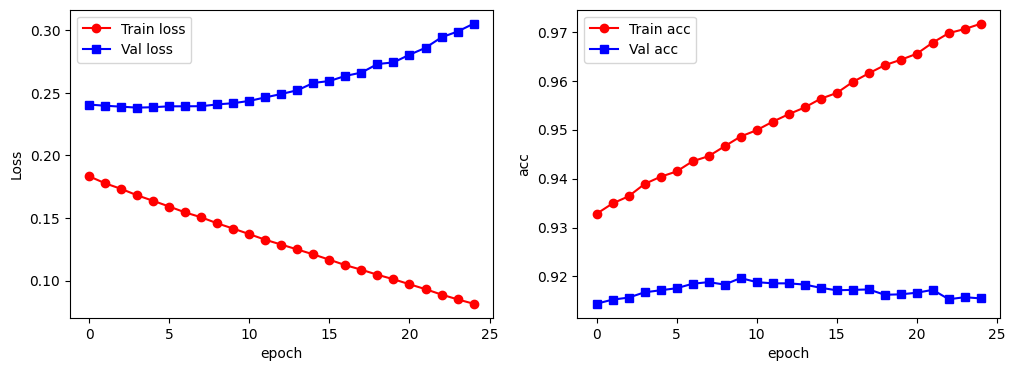

In [60]:
# 可视化模型训练过程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label = "Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [63]:
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精度为：", acc)

在测试集上的预测精度为： 0.9166


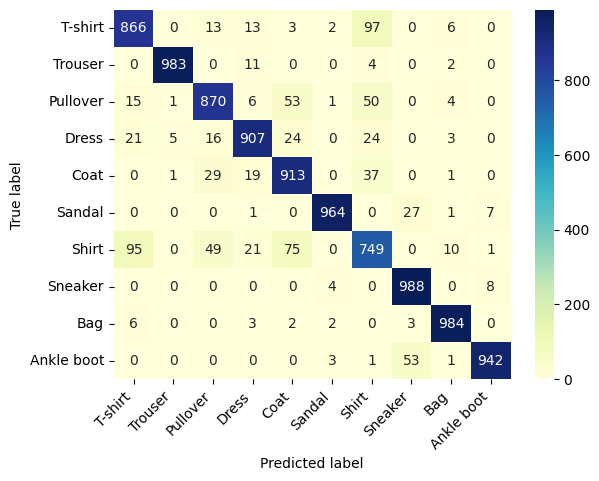

In [65]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 6.3.4 空洞卷积神经网络的搭建

> 在PyTorch库中使用nn.Conv2d()函数，通过调节参数dilation的取值，进行不同大小卷积核的空洞卷积运算

In [73]:
class MyConvdilaNet(nn.Module):
    def __init__(self):
        super(MyConvdilaNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 3,
                stride = 1,
                padding = 1,
                dilation = 2
            ), # 卷积后：(1*28*28)转化为(16*26*26)
            nn.ReLU(),
            nn.AvgPool2d(2, 2) # 池化后：(16*26*26)转换为（16*13*13）
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 0,
                dilation = 2
            ), # 卷积后：(16*13*13)转换为(32*9*9)
            nn.ReLU(),
            nn.AvgPool2d(2, 2) # 池化后：(32*9*9)转换为(32*4*4)
        )
        # 定义全连接层
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    # 定义网络的向前传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output

# 输出网络结构
myconvdilanet = MyConvdilaNet()

### 6.3.5 空洞卷积神经网络训练与预测

In [75]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvdilanet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
mycondilanet, train_process = train_model(myconvdilanet, train_loader, 0.8, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0Train Loss:  0.9211 Train Acc:  0.6639
0Val Loss:  0.6570 val Acc:  0.7423
Train and val complete in 0m 10s
Epoch 1/24
----------
1Train Loss:  0.6258 Train Acc:  0.7578
1Val Loss:  0.5742 val Acc:  0.7782
Train and val complete in 0m 18s
Epoch 2/24
----------
2Train Loss:  0.5571 Train Acc:  0.7864
2Val Loss:  0.5208 val Acc:  0.8006
Train and val complete in 0m 26s
Epoch 3/24
----------
3Train Loss:  0.5110 Train Acc:  0.8043
3Val Loss:  0.4867 val Acc:  0.8158
Train and val complete in 0m 35s
Epoch 4/24
----------
4Train Loss:  0.4759 Train Acc:  0.8207
4Val Loss:  0.4607 val Acc:  0.8291
Train and val complete in 0m 43s
Epoch 5/24
----------
5Train Loss:  0.4482 Train Acc:  0.8329
5Val Loss:  0.4378 val Acc:  0.8399
Train and val complete in 0m 52s
Epoch 6/24
----------
6Train Loss:  0.4253 Train Acc:  0.8423
6Val Loss:  0.4190 val Acc:  0.8468
Train and val complete in 1m 0s
Epoch 7/24
----------
7Train Loss:  0.4058 Train Acc:  0.8496
7Val Loss:  0.4020 val

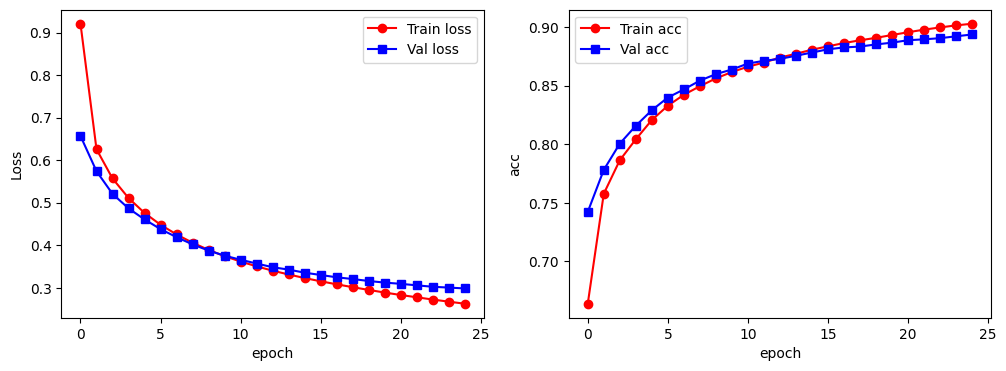

In [76]:
# 可视化模型训练过程中的精度和损失函数
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label = "Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label = "Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label = "Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [77]:
# 对测试集进行预测，并可视化预测效果
myconvdilanet.eval()
output = myconvdilanet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精度为：", acc)

在测试集上的预测精度为： 0.886


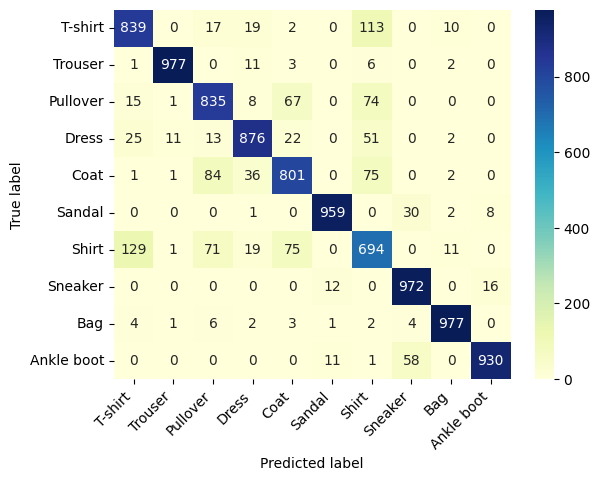

In [78]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()